The script for the ratios prediction is given below

In [ ]:
# Import the basic libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle
import sys
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Set up the path for importing the python codes need
sys.path.extend(['/content/drive/My Drive/cocrystal_design/models',
                 '/content/drive/My Drive/cocrystal_design/notebooks/python_codes' ])

In [ ]:
# Import the neural network architectures and libraries
%cd /content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
%cd src/set_transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn.functional as F
from modules import SAB, PMA, ISAB
import tqdm
#torch.cuda.empty_cache()
#torch.cuda.is_available() 
% cd ..
from base.torchvision_dataset import TorchvisionDataset
import logging
import random
from utils.config import Config
#from utils.visualization.plot_images_grid import plot_images_grid
import deepSVDD
#from datasets.main import load_dataset
from base.base_net import BaseNet
#from collections import namedtuple

/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src/set_transformer
/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/src


In [ ]:
cfg = Config({'normal_class': 1, 
              'n_jobs_dataloader': 0, 
              'ae_weight_decay': 0.0005, 
              'ae_batch_size': 200, 
              'ae_lr_milestone': (50,), 
              'ae_n_epochs': 5, 
              'ae_lr': 0.0001,
              'ae_optimizer_name': 'adam', 
              'pretrain': True, 
              'weight_decay': 5e-07,
              'batch_size': 200, 
              'lr_milestone': (50,),
              'n_epochs': 5, 
              'lr': 0.0001, 
              'optimizer_name': 'adam', 
              'seed': -1, 
              'device': 'cuda', 
              'nu': 0.05, 
              'objective':  'one-class', 
              'load_model': None, 
              'load_config': None,'dataset_name': 'cocry', 'net_name': 'CocryNet'})

dataset_name = cfg.settings['dataset_name']
normal_class = cfg.settings['normal_class']
net_name = cfg.settings['net_name']
n_jobs_dataloader = 0

In [ ]:
INPUT_DIM =  1857

class PairsEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.rep_dim = 100
        self.seq = nn.Sequential(SAB(dim_in=1857, dim_out=1000, num_heads=10),
            SAB(dim_in=1000, dim_out=500, num_heads=10),
            SAB(dim_in=500, dim_out=100, num_heads=10),
            PMA(dim=100, num_heads=5, num_seeds=1))
        
    def forward(self, x):
      x = torch.split(x, 1857, dim=1)     
      x= torch.stack(x).transpose(0,1) 
      return self.seq(x).squeeze()

class PairsAutoEncoder(BaseNet):

    def __init__(self):
        super().__init__()
        self.encoder = PairsEncoder()
        self.encoder.apply(init_weights)
        self.decoder = nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
        self.decoder.apply(init_weights)


## nn.Sequential(nn.Linear(in_features=100, out_features=3714), nn.Sigmoid())
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
def build_autoencoder(net_name):
    return PairsAutoEncoder()
    #return nn.Sequential()~

def build_network(net_name):
  
  return PairsEncoder()
    #return nn.Sequential()
torch.manual_seed(0)
deepSVDD.build_network = build_network
deepSVDD.build_autoencoder = build_autoencoder

In [ ]:
# Load the deep learning model
torch.manual_seed(0)

deep_SVDD = deepSVDD.DeepSVDD(cfg.settings['objective'], cfg.settings['nu'])
net_name='model_checkpoint.pth'
deep_SVDD.set_network(net_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
deep_SVDD.load_model('/content/drive/My Drive/cocrystal_design/models/Deep-SVDD-PyTorch/model_checkpoint2.pth')

In [ ]:
# Import the datasets

dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv')
dataset1.head()

# Dataset with ratios
dictionar=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/cocrystal_ratios.csv')
keys = dictionar.iloc[:, 0].values
values = dictionar.iloc[:, 3:7].values
d = {key:value for key, value in zip(keys, values)}

In [ ]:
# Assign to each combination their molecular ratio and their Z number
ratios=[]
for x in dataset2['Identifier'].values:
  ratios.append(d[x])  
ratio=pd.DataFrame(ratios, columns=['Z', 'mol1', 'mol2', 'ratios'])  
rat=pd.concat([dataset2 ,ratio], axis=1)
dataset = rat.drop(['mol1', 'mol2'], axis=1)
d2=dataset.drop(['Identifier', 'NAME'], axis=1)
d1= dataset1.insert(loc=2, column='NAME2', value=dataset['NAME'])
dataset_ratios=pd.concat([dataset1, d2], axis=1)


In [ ]:
df1=dataset1.iloc[:,3:]
df1 = df1.fillna(df1.mean())
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(df2.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]


In [ ]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict= {key:value for key, value in zip(k1, v1)}
print(dict['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset1, dataset2):

  return pd.concat([pd.concat([dataset['Identifier'], dataset1, dataset2], axis=1), pd.concat([dataset['Identifier'].apply(lambda x: f"{x}_"),dataset2, dataset1], axis=1) ])


In [ ]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
#X_scaler = StandardScaler()

df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df_ratios = pd.concat([df, pd.concat([dataset['ratios'], dataset['ratios']])], axis=1)
df_ratios.tail()

Identifier        MW       AMW  ...  Infective-80  Infective-50  ratios
1717    AFOTIB_  0.007336  0.048022  ...      0.000000      0.000000     1/3
1718    CIQNIC_  0.007336  0.048022  ...      0.000000      0.000000     1/2
1719    DIVZUG_  0.007336  0.048022  ...      0.000000      0.000000     1/2
1720    PIQTOB_  0.007336  0.048022  ...      0.193697      0.033051     1/2
1721    RAWXEU_  0.002560  0.075504  ...      0.000000      0.000000     1/2

[5 rows x 3716 columns]

In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
# Scoring the labelled and unlabelled data
from sklearn.preprocessing import MinMaxScaler
y_scaler1 = MinMaxScaler()

lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
lab= y_scaler1.fit_transform(lab.reshape(-1,1))
#uf_final= uf_final.fillna(0)
#unlab = score(deep_SVDD, uf_final.iloc[:,1:].values).cpu().detach().numpy()*-1
#unlab = y_scaler1.transform(unlab.reshape(-1,1))

print(len(lab))
#print(len(unlab))

1722


In [ ]:
lab=pd.DataFrame(lab, columns=['train_score'])
lab.describe()

train_score
count  1722.000000
mean      0.828226
std       0.120277
min       0.000000
25%       0.785037
50%       0.860010
75%       0.906288
max       1.000000

In [ ]:
# Import the libraries
!pip install shap

     |████████████████████████████████| 276kB 6.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394117 sha256=e5fd77c5bccc3f546b414797b6a33c2b23fbb1ed79d28c8845d140e8454c6a19
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [ ]:
def score(deep_SVDD, X):
    with torch.no_grad():
        net = deep_SVDD.net.to(device)
        X = torch.FloatTensor(X).to(device)
        y = net(X)
        c, R = torch.FloatTensor([deep_SVDD.c]).to(device), torch.FloatTensor([deep_SVDD.R]).to(device)
        dist = torch.sum((y - c)**2, dim=1)
        if deep_SVDD.objective == 'soft-boundary':
            scores = dist - R ** 2
        else:
            scores = dist
    return scores

In [ ]:
class  CocryNet(nn.Module):
    def __init__(self, net, R, C):
      
        super().__init__()
        self.net = net
        self.R = torch.Tensor([R]).to("cuda")
        self.C = torch.Tensor([C]).to("cuda")

    def forward(self, x):
        #x = torch.FloatTensor(x).cpu().to(device)
        outputs = self.net(x)
        dist = torch.sum((outputs - self.C) ** 2, dim=1)
        scores = (dist - self.R ** 2)*-1
        lab = score(deep_SVDD, df.iloc[:1722,1:].values).cpu().detach().numpy()*-1 
        M= lab.max()
        m= lab.min()
        scores = (scores - m)/(M-m)
        return scores.unsqueeze(1)
shapNet = CocryNet(deep_SVDD.net, deep_SVDD.R, deep_SVDD.c)

In [ ]:
df1=dataset1.iloc[:,3:]
labels1 = df1.rename(columns=lambda x: f"{x}_1")
labels2 = df1.rename(columns=lambda x: f"{x}_2")
dataset1_labels = labels1.columns.values
dataset2_labels = labels2.columns.values

cols = np.concatenate((dataset1_labels, dataset2_labels))

In [ ]:

# Interpretability of the whole bidirectional dataset
import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(df.iloc[:, 1:].values).to(device)
model = shapNet#.to(device)

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#e = shap.KernelExplainer(model, background)
shap_values = e.shap_values(background, rseed=20, ranked_outputs=10)


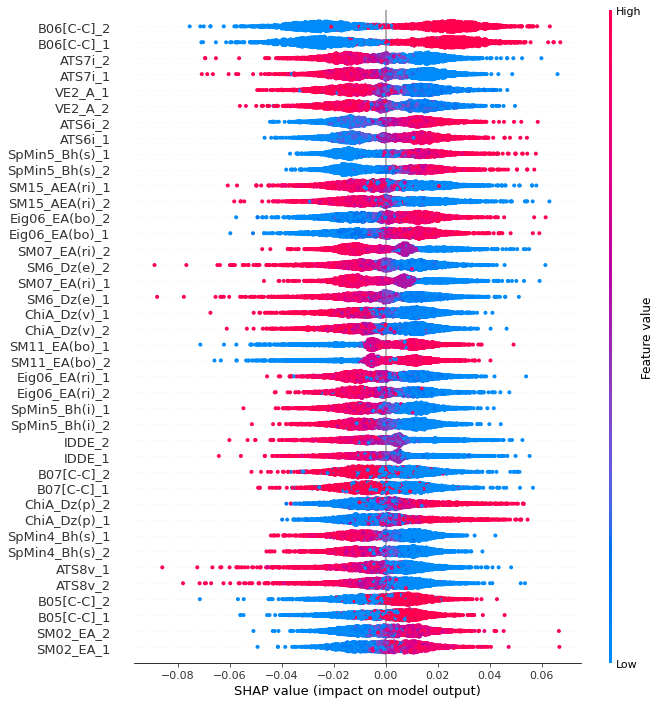

In [ ]:
# Plot the most important features 

X = pd.DataFrame(df.iloc[:, 1:].values, columns=cols) 

shap.summary_plot(shap_values, X ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=30, class_names=None, max_display=40,  show=False)

#plt.savefig('shap_lab.svg')  

In [ ]:
dataset = pd.concat([pd.DataFrame(df.iloc[:, 0].values, columns=['Identifier']), pd.DataFrame(shap_values, columns=df.columns.values[1:]) ], axis=1)
dataset

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
0        WOVMEB -0.002608  0.000480  ...      -0.000067     -0.000321  5.452678e-05
1        PIWKEL  0.000512 -0.000848  ...       0.000175      0.013498  2.059253e-04
2        OTIHIJ -0.001090 -0.000429  ...      -0.000563      0.001384 -1.496132e-04
3        DABLOJ -0.001962 -0.000848  ...       0.000227      0.000256  3.493337e-08
4        PIGJUK -0.000110  0.000731  ...       0.000450      0.003767 -3.819527e-04
...         ...       ...       ...  ...            ...           ...           ...
3439    AFOTIB_  0.001287  0.000998  ...       0.000145      0.000540  1.874559e-04
3440    CIQNIC_  0.002317  0.000588  ...      -0.000157     -0.000951  1.258506e-04
3441    DIVZUG_  0.001016  0.000804  ...      -0.000200      0.003151 -2.780442e-05
3442    PIQTOB_ -0.000912 -0.001328  ...       0.000417      0.000543  8.633508e-05
3443    RAWXEU_  0.004774  0.000441  ...       0.000053     -0.000059 -3.326142e-05

[3444 rows x 3715 columns]

In [ ]:
pyrene1= dataset[dataset.Identifier.isin(pyrene1)]

In [ ]:
pyr_switch
pyr2 = dataset[dataset.Identifier.isin(pyr_switch)]
pyr2.iloc[:, 1:]

pyrene2  = pd.concat([py2.iloc[:,0] , pyr2.iloc[:, 1858:], pyr2.iloc[:, 1:1858]], axis=1)

In [ ]:
# Add interpretability to pyrene co-crystals

pyrene_cocrystals1 = dataset1[dataset1.NAME == 'c1cc2ccc3cccc4ccc(c1)c2c34']
pyrene_cocrystals2 = dataset2[dataset2.NAME == 'c1cc2ccc3cccc4ccc(c1)c2c34']
pyrene_cocrystals = pd.concat([pyrene_cocrystals1, pyrene_cocrystals2]).Identifier.values
len(pyrene_cocrystals)

52

In [ ]:
shapley_labelled = pd.concat([pd.DataFrame(df.Identifier.values, columns=['Identifier']), pd.DataFrame(shap_values, columns=df.columns.values[1:])], axis=1)
#shapley_labelled = shapley_labelled[shapley_labelled.Identifier.isin(train_inl)]
#s_val = shapley_labelled.iloc[:,1:1858 ]


In [ ]:
pyr1 = dataset1[dataset1.Identifier.isin(pyrene_cocrystals)]
pyrene1 = pyr1[pyr1.NAME  == 'c1cc2ccc3cccc4ccc(c1)c2c34'].Identifier
pyr_switch = pyr1[pyr1.NAME  != 'c1cc2ccc3cccc4ccc(c1)c2c34'].Identifier
X = df[df.Identifier.isin(pyrene_cocrystals)]
#X = X_inl[X_inl.Identifier.isin(pyrene_cocrystals)]
pyrene1= X[X.Identifier.isin(pyrene1)]


In [ ]:
pyr_switch
pyr2 = X[X.Identifier.isin(pyr_switch)]
pyr2.iloc[:, 1:]

pyrene2  = pd.concat([py2.iloc[:,0] , pyr2.iloc[:, 1858:], pyr2.iloc[:, 1:1858]], axis=1)


In [ ]:
#pyrene1= df[df.Identifier.isin(pyrene1)]
#pyrene2= df[df.Identifier.isin(pyrene2)]

In [ ]:
shapley_labelled = shapley_labelled[shapley_labelled.Identifier.isin(pyrene_cocrystals)]
shapley_labelled
pyrene1= shapley_labelled[shapley_labelled.Identifier.isin(pyrene1)]
#pyrene1= X[X.Identifier.isin(pyrene1)]
#pyr_val = shapley_labelled.iloc[:,1:1858 ]

In [ ]:
#X = df[df.Identifier.isin(pyrene_cocrystals)]
#py2 = shapley_labelled[shapley_labelled.Identifier.isin(pyr_switch)]
#pyrene1= X[X.Identifier.isin(pyrene1)]
#pyrene2  = pd.concat([py2.iloc[:,0] , py2.iloc[:, 1858:], py2.iloc[:, 1:1858]], axis=1)

In [ ]:
# Pyrene molecule is set in position 2, so we are focusing on the constributions of the second coformer
pyrene_dataset = pd.concat([pyrene1, pyrene2], axis=0)
pyrene_dataset#.iloc[:, 1858:] #.shape

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
64       TUYVUF  0.000735  0.000198  ...      -0.000014      0.000772  3.742214e-07
84       AYEGAM  0.002290  0.000311  ...       0.000040     -0.000005  3.075749e-04
85       BAZCUA  0.001061  0.000861  ...      -0.000021     -0.000698 -1.993344e-05
86       BAZDAH  0.000511 -0.000104  ...      -0.000256     -0.001832 -2.102316e-02
87       BORPII -0.000062 -0.000231  ...       0.000284     -0.002382  3.849895e-04
99       CILRAQ  0.000872  0.000221  ...       0.000042      0.012572 -4.679590e-04
100      CORPIJ -0.000999 -0.000344  ...       0.000638     -0.000914  1.020045e-03
102      CUNWUD -0.001016 -0.000135  ...      -0.000064     -0.001329  4.200580e-04
109      ECUVIH -0.001147  0.000204  ...       0.000237     -0.010425 -2.672966e-04
110      EHESIT  0.001306 -0.000076  ...       0.000430     -0.004170 -7.102800e-05
111      EHESOZ -0.001138 -0.000115  ...      -0.000205     -0.003797  5.032332e-04
117      FARNIX -0.001707 -0.000293  ...      -0.000608     -0.015817  9.848536e-05
127      GUMNUY -0.000508 -0.000121  ...       0.000043     -0.007738  5.353228e-06
128      GUQRAN -0.000825 -0.000080  ...      -0.000126      0.000736 -1.314586e-04
130      HAYYOW  0.002007  0.000981  ...      -0.000135      0.006603  9.168122e-05
140      MIDDEL -0.000382 -0.000029  ...       0.000010     -0.000039  1.261656e-05
165    PYRBZQ01  0.000892  0.000067  ...       0.000009     -0.000101  5.358108e-04
167      PYRCLN -0.000337 -0.000541  ...       0.000277     -0.008676  2.877892e-04
169    PYRFLR01 -0.001163 -0.000131  ...       0.000052     -0.001069 -2.202493e-05
170    PYRPMA11  0.000985  0.000106  ...       0.000113      0.003930  2.361759e-05
171    PYRTCQ03  0.002062  0.000048  ...       0.000090     -0.001254  6.273072e-05
172      PYRTNB  0.000219  0.000268  ...      -0.000230      0.013179  4.246895e-04
173      PYTQIM  0.000461 -0.000116  ...      -0.000096      0.021131  1.644220e-02
175      QEVWEW  0.000400  0.000268  ...      -0.000543     -0.003468 -1.055599e-04
177      QEVXOH  0.000772  0.000062  ...      -0.000225     -0.016312  1.584084e-04
179    REDCIM01  0.000352  0.000057  ...       0.000040     -0.008199 -4.436460e-05
181      REDFIP  0.000076  0.000328  ...      -0.000044     -0.007643 -4.656031e-05
200      UZEGOX  0.002403  0.000150  ...       0.000376     -0.001102  4.423990e-04
207      WAWPAM  0.001574 -0.000270  ...      -0.000070      0.003803 -1.334973e-05
213    ZZZGKE02 -0.000054 -0.000131  ...      -0.000155     -0.001075  8.141545e-05
1127     AGOREW -0.000351 -0.000127  ...      -0.000042      0.000088 -2.933704e-03
1215     CUSZUM -0.000255  0.000350  ...       0.009202      0.015139  4.980374e-04
1217     EHETEQ  0.001113  0.000050  ...      -0.000048     -0.003303 -7.107638e-05
1222     GUQQEQ -0.001203 -0.000259  ...      -0.000065      0.000199 -2.694169e-05
1223     GUQQIU -0.001395 -0.000131  ...      -0.000161     -0.001558  2.822434e-04
1224     GUQQOA -0.002063 -0.000458  ...      -0.000403      0.000867 -1.752520e-04
1225     GUQQUG -0.000553 -0.000149  ...      -0.000112      0.002379  1.298215e-04
1228     ISISAG  0.000517 -0.000181  ...       0.000054     -0.001954  3.753096e-04
1230     MIDDIP  0.000294  0.000041  ...       0.000022      0.001534 -6.418394e-05
1231     PYRBPC  0.000748 -0.000107  ...      -0.000445      0.010917  4.063243e-04
1233     REQVOZ -0.000284 -0.000259  ...       0.000088     -0.014956 -9.791202e-06

[41 rows x 3715 columns]

In [ ]:
# Interprete the Unlabelled Dataset

import shap

import numpy as np

# select a set of background examples to take an expectation over
device = 'cuda'
background = torch.FloatTensor(pyrene_dataset.iloc[:, 1:].values).to(device) #df.iloc[:, 1:].values  #test.iloc[:, 1:]. #(uf_final.iloc[:,1:]  #uf.iloc[:, :].values
model = shapNet 

# explain predictions of the model on the training set
e = shap.GradientExplainer(model, background)#, link = 'logit')      

#e = shap.KernelExplainer(model, background)
shap_values_pyr = e.shap_values(background, rseed=1, ranked_outputs=20)


In [ ]:

shapley_pyrene = pd.concat([pd.DataFrame(pyrene_dataset.Identifier.values, columns=['Identifier']), pd.DataFrame(shap_values_pyr, columns=df.columns.values[1:])], axis=1)
pyrene_coform = shapley_pyrene.iloc[:, 1858: ] #1858:

pyrene_coform.shape

(52, 1857)

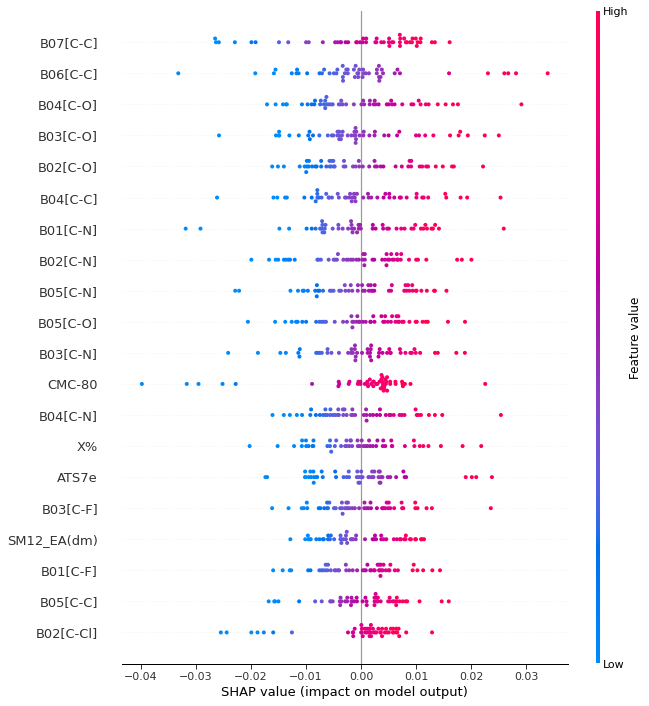

In [ ]:
# Plot the most important features 
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['font.family'] = 'sans-serif'
sns.set_context("paper", rc={"axes.labelsize":8} )

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)#, aspect='equal')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
#X = pyrene_dataset.iloc[:, 1:] #pd.DataFrame(X_inl.iloc[:, 1:1858].values, columns=df.iloc[:, 1:1858].columns.values) 

X1 = pd.DataFrame(pyrene_coform.iloc[:, :].values, columns=pyrene_dataset.iloc[:, 1:1858].columns.values) 

shap.summary_plot(pyrene_coform.iloc[:, :].values , X1 ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=20, class_names=None, max_display=20,  show=False)

#plt.savefig('shap_pyr.svg')
#, color='r', axis_color="#333333", title=None, alpha=0.8, show=True, sort=True,
          #      

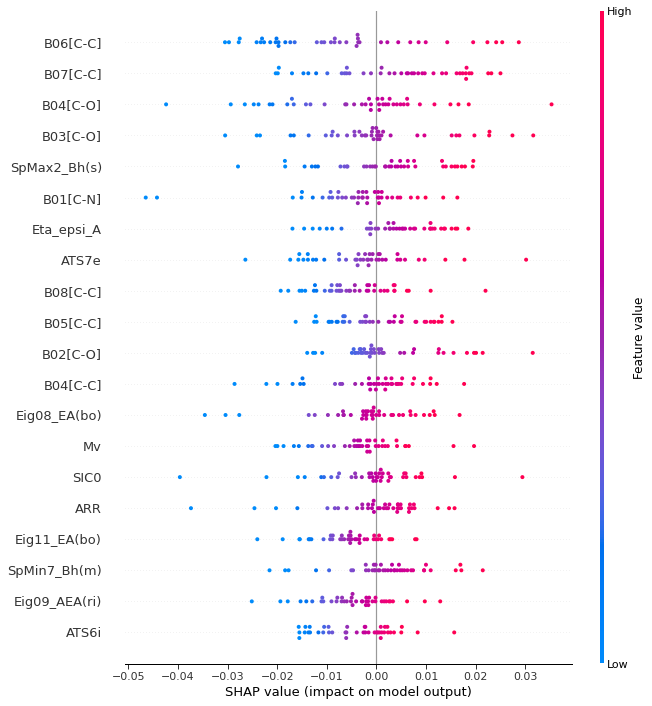

In [ ]:
# Plot the most important features 
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "light"
plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['font.family'] = 'sans-serif'
sns.set_context("paper", rc={"axes.labelsize":8} )

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)#, aspect='equal')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.axis('on')
ax.grid(False)
ax.set_facecolor('xkcd:white')
#X = pyrene_dataset.iloc[:, 1:] #pd.DataFrame(X_inl.iloc[:, 1:1858].values, columns=df.iloc[:, 1:1858].columns.values) 

X1 = pd.DataFrame(pyrene_dataset.iloc[:, 1858:].values, columns=pyrene_dataset.iloc[:, 1858:].columns.values) 

shap.summary_plot(pyrene_dataset.iloc[:,1858:].values , X1 ,  color_bar=True, plot_size=(10,12), layered_violin_max_num_bins=20, class_names=None, max_display=20,  show=False)

#plt.savefig('shap_pyr.svg')
#, color='r', axis_color="#333333", title=None, alpha=0.8, show=True, sort=True,
          #      

# Connecting the most important Shapley values with understandable descriptors by calculating the correlation between them

In [ ]:
df1_w=dataset1.iloc[:,2:]
df2_w=dataset2.iloc[:,2:]
data = pd.concat([df1_w, df2_w])
data_ = data.drop_duplicates(keep=False)
print(df1_w.shape)
print(df2_w.shape)

# Drop the highly linearly correlated features among the datasets
# Create correlation matrix

corr_matrix1 = data_.corr(method='spearman').abs()


(1722, 1857)
(1722, 1857)


In [ ]:
# Create the correlation matrix
c1 = corr_matrix1.abs().unstack()
c1['SpMin5_Bh(s)'].sort_values(ascending = False)[0:50] 

# Visualizing the descriptors distribution

In [ ]:
# Import the labeled dataset without scalling
dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv')
dataset1.head()

Identifier  ... Infective-50
0     WOVMEB  ...          0.0
1     PIWKEL  ...          1.0
2     OTIHIJ  ...          0.0
3     DABLOJ  ...          0.0
4     PIGJUK  ...          0.0

[5 rows x 1859 columns]

In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset11, dataset22], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
# Standarize the dataset
# Standarize the data

df1=dataset1.iloc[:,2:]
df1 = df1.fillna(0)
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(0)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1,df2)
df

Identifier      MW     AMW  ...  Neoplastic-50  Infective-80  Infective-50
0        WOVMEB  106.18   5.899  ...            0.0           0.0           0.0
1        PIWKEL  264.24   9.437  ...            0.0           1.0           0.0
2        OTIHIJ  520.76   6.852  ...            0.0           0.0           0.0
3        DABLOJ   88.12   6.294  ...            0.0           0.0           0.0
4        PIGJUK  332.56  10.393  ...            0.0           0.0           0.0
...         ...     ...     ...  ...            ...           ...           ...
1717    AFOTIB_   92.15   6.143  ...            0.0           0.0           0.0
1718    CIQNIC_   92.15   6.143  ...            0.0           0.0           0.0
1719    DIVZUG_   92.15   6.143  ...            0.0           0.0           0.0
1720    PIQTOB_   92.15   6.143  ...            0.0           0.0           0.0
1721    RAWXEU_   79.11   7.192  ...            0.0           0.0           0.0

[3444 rows x 3715 columns]

In [ ]:
# Import the unlabeled dataset without scalling
final_1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabeled11.csv')
final_2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabeled22.csv')


In [ ]:
uf=pd.concat([final_1, final_2], axis =1)
comb=[]
for i in range(1,final_1.shape[0]+1):
  comb.append('comb%s' % i)
uf_final=pd.concat([pd.DataFrame(comb, columns=['comb']),final_1, final_2 ], axis=1)
uf_final

comb      MW     AMW  ...  Neoplastic-50  Infective-80  Infective-50
0          comb1  232.24   8.932  ...            0.0           1.0           0.0
1          comb2  232.24   8.932  ...            0.0           1.0           0.0
2          comb3  232.24   8.932  ...            0.0           0.0           0.0
3          comb4  232.24   8.932  ...            0.0           0.0           0.0
4          comb5  232.24   8.932  ...            0.0           1.0           0.0
...          ...     ...     ...  ...            ...           ...           ...
21731  comb21732  275.35   7.649  ...            0.0           1.0           0.0
21732  comb21733  275.35   7.649  ...            0.0           0.0           0.0
21733  comb21734  164.60  10.288  ...            0.0           1.0           0.0
21734  comb21735  164.60  10.288  ...            0.0           0.0           0.0
21735  comb21736  250.30   8.343  ...            0.0           0.0           0.0

[21736 rows x 3715 columns]

In [ ]:
dataset1= dataset1.fillna(0)
dataset2 = dataset2.fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


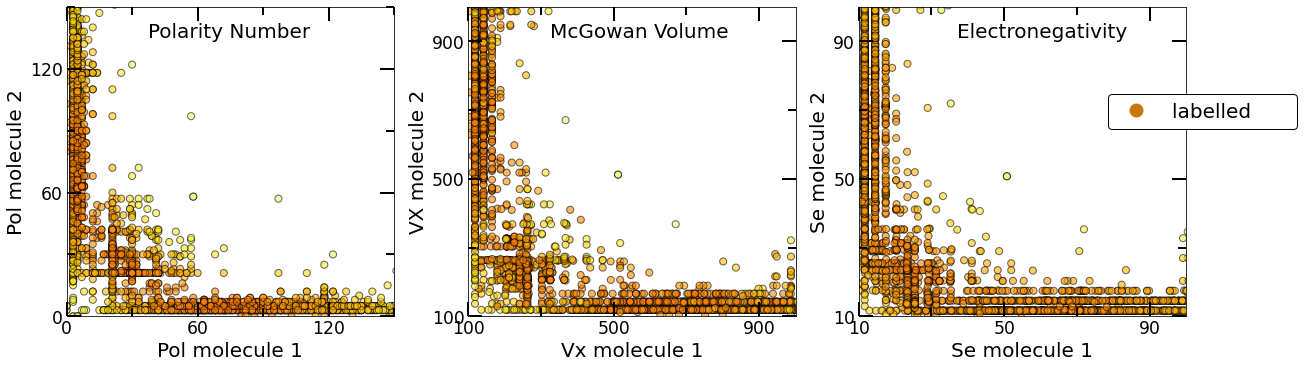

In [ ]:
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
x1= pd.concat([dataset1['Pol'] , dataset2['Pol']])  # dataset1['Ram']
y1= pd.concat([dataset2['Pol'] , dataset1['Pol']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
#z=lab
ax0.text(0.25, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia)#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
# Experomental Compounds

ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(0, 150)
ax0.set_ylim(0, 150)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 150.1, 60)
minor_ticks_x = np.arange(0, 150.1, 30)
major_ticks_y = np.arange(0, 150.1, 60)
minor_ticks_y = np.arange(0, 150.1, 30)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)

#Volume
x1= pd.concat([dataset1['Vx'] , dataset2['Vx']])  # dataset1['Ram']
y1= pd.concat([dataset2['Vx'] , dataset1['Vx']])
z = gaussian_kde(x1y1)(x1y1)

ax1.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.25, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
# Experimental COmpounds

ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(100, 1000)
ax1.set_ylim(100, 1000)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(100, 1000, 400)
minor_ticks_x = np.arange(100, 1000, 200)
major_ticks_y = np.arange(100, 1000, 400)
minor_ticks_y = np.arange(100, 1000, 200)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

#Electronic
x1= pd.concat([dataset1['Se'] , dataset2['Se']])  # dataset1['Ram']
y1= pd.concat([dataset2['Se'] , dataset1['Se']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)

ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Labelled')#plt.cm.Wistia)#, zorder=2)
ax2.text(0.3, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
    
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(10, 100)
ax2.set_ylim(10, 100)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100, 40)
minor_ticks_x = np.arange(10, 100, 20)
major_ticks_y = np.arange(10, 100, 40)
minor_ticks_y = np.arange(10, 100, 20)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
#fig.colorbar(ax2=ax2, orientation='horizontal')



#leg = plt.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
         #   borderaxespad=1, frameon=False) loc=(0.75, -0.15),

from matplotlib.lines import Line2D
red_circle = Line2D([0], [0], marker='o', color='w', label='labelled      ', 
                        markerfacecolor='#c87606', markersize=15),
plt.legend(handles=red_circle, bbox_to_anchor= (0.73, 0.75) , ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')  # bbox_to_anchor= (1.2, 0.65)

#plt.savefig('figure9_lab_scores.png', dpi=600)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


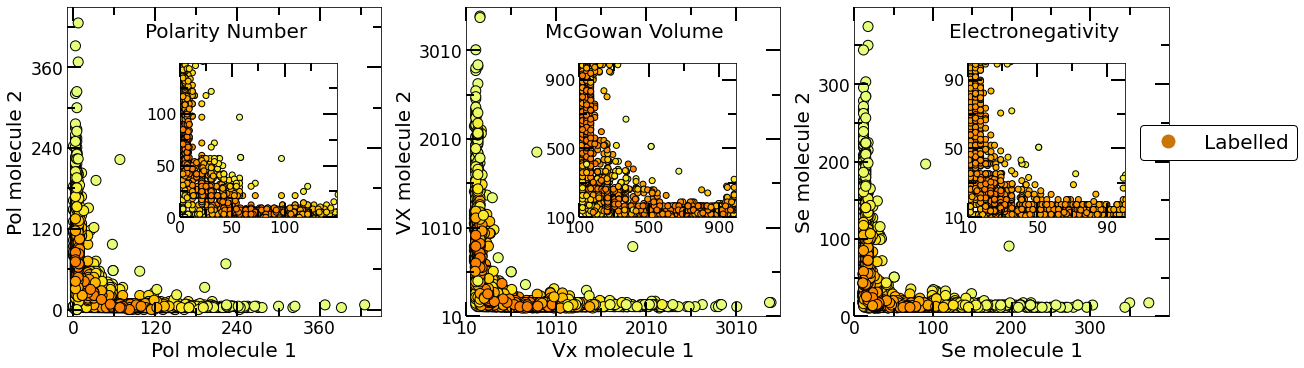

In [ ]:
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
x1= pd.concat([dataset1['Pol'] , dataset2['Pol']])  # dataset1['Ram']
y1= pd.concat([dataset2['Pol'] , dataset1['Pol']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
#z=lab
ax0.text(0.25, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black',  cmap=plt.cm.Wistia)#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(-10, 450)
ax0.set_ylim(-10, 450)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 450, 120)
minor_ticks_x = np.arange(0, 450, 60)
major_ticks_y = np.arange(0, 450, 120)
minor_ticks_y = np.arange(0, 450, 60)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
sub_axes = ax0.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(0, 150)
sub_axes.set_ylim(0, 150)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 150, 50)
minor_ticks_x = np.arange(0, 150, 25)
major_ticks_y = np.arange(0, 150, 50)
minor_ticks_y = np.arange(0, 150, 25)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)


#Volume
x1= pd.concat([dataset1['Vx'] , dataset2['Vx']])  # dataset1['Ram']
y1= pd.concat([dataset2['Vx'] , dataset1['Vx']])
z = gaussian_kde(x1y1)(x1y1)

ax1.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black', cmap=plt.cm.Wistia, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.25, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(10, 3500)
ax1.set_ylim(10, 3500)
major_ticks_x = np.arange(10,  3500, 1000)
minor_ticks_x = np.arange(10,  3500, 500)
major_ticks_y = np.arange(10, 3500, 1000)
minor_ticks_y = np.arange(10,  3500, 500)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
sub_axes = ax1.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(100, 1000)
sub_axes.set_ylim(100, 1000)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(100, 1000, 400)
minor_ticks_x = np.arange(100, 1000, 200)
major_ticks_y = np.arange(100, 1000, 400)
minor_ticks_y = np.arange(100, 1000, 200)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)


#Electronic
x1= pd.concat([dataset1['Se'] , dataset2['Se']])  # dataset1['Ram']
y1= pd.concat([dataset2['Se'] , dataset1['Se']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)

ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Labelled')#plt.cm.Wistia)#, zorder=2)
ax2.text(0.3, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
    
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(0, 400)
ax2.set_ylim(0, 400)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 400, 100)
minor_ticks_x = np.arange(0, 400, 50)
major_ticks_y = np.arange(0, 400, 100)
minor_ticks_y = np.arange(0, 400, 50)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
#fig.colorbar(ax2=ax2, orientation='horizontal')
sub_axes = ax2.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(10, 100)
sub_axes.set_ylim(10, 100)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100.1, 40)
minor_ticks_x = np.arange(10, 100.1, 20)
major_ticks_y = np.arange(10, 100.1, 40)
minor_ticks_y = np.arange(10, 100.1, 20)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)



#leg = plt.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
         #   borderaxespad=1, frameon=False) loc=(0.75, -0.15),

from matplotlib.lines import Line2D
red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
plt.legend(handles=red_circle,  bbox_to_anchor= (1.44, 0.65), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')

plt.savefig('figure9_lab_scores_inset.png', dpi=600)

In [ ]:
# Import the labeled dataset without scalling
dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv')
dataset1.head()

Identifier  ... Infective-50
0     WOVMEB  ...          0.0
1     PIWKEL  ...          1.0
2     OTIHIJ  ...          0.0
3     DABLOJ  ...          0.0
4     PIGJUK  ...          0.0

[5 rows x 1859 columns]

In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset11, dataset22], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
# Standarize the dataset
# Standarize the data

df1=dataset1.iloc[:,2:]
df1 = df1.fillna(0)
df2=dataset2.iloc[:,2:]
df2 = df2.fillna(0)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1,df2)
df

Identifier      MW     AMW  ...  Neoplastic-50  Infective-80  Infective-50
0        WOVMEB  106.18   5.899  ...            0.0           0.0           0.0
1        PIWKEL  264.24   9.437  ...            0.0           1.0           0.0
2        OTIHIJ  520.76   6.852  ...            0.0           0.0           0.0
3        DABLOJ   88.12   6.294  ...            0.0           0.0           0.0
4        PIGJUK  332.56  10.393  ...            0.0           0.0           0.0
...         ...     ...     ...  ...            ...           ...           ...
1717    AFOTIB_   92.15   6.143  ...            0.0           0.0           0.0
1718    CIQNIC_   92.15   6.143  ...            0.0           0.0           0.0
1719    DIVZUG_   92.15   6.143  ...            0.0           0.0           0.0
1720    PIQTOB_   92.15   6.143  ...            0.0           0.0           0.0
1721    RAWXEU_   79.11   7.192  ...            0.0           0.0           0.0

[3444 rows x 3715 columns]

In [ ]:
# Import the unlabeled dataset without scalling
final_1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabeled11.csv')
final_2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabeled22.csv')


In [ ]:
uf=pd.concat([final_1, final_2], axis =1)
comb=[]
for i in range(1,final_1.shape[0]+1):
  comb.append('comb%s' % i)
uf_final=pd.concat([pd.DataFrame(comb, columns=['comb']),final_1, final_2 ], axis=1)
uf_final

comb      MW     AMW  ...  Neoplastic-50  Infective-80  Infective-50
0          comb1  232.24   8.932  ...            0.0           1.0           0.0
1          comb2  232.24   8.932  ...            0.0           1.0           0.0
2          comb3  232.24   8.932  ...            0.0           0.0           0.0
3          comb4  232.24   8.932  ...            0.0           0.0           0.0
4          comb5  232.24   8.932  ...            0.0           1.0           0.0
...          ...     ...     ...  ...            ...           ...           ...
21731  comb21732  275.35   7.649  ...            0.0           1.0           0.0
21732  comb21733  275.35   7.649  ...            0.0           0.0           0.0
21733  comb21734  164.60  10.288  ...            0.0           1.0           0.0
21734  comb21735  164.60  10.288  ...            0.0           0.0           0.0
21735  comb21736  250.30   8.343  ...            0.0           0.0           0.0

[21736 rows x 3715 columns]

In [ ]:
dataset1= dataset1.fillna(0)
dataset2 = dataset2.fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


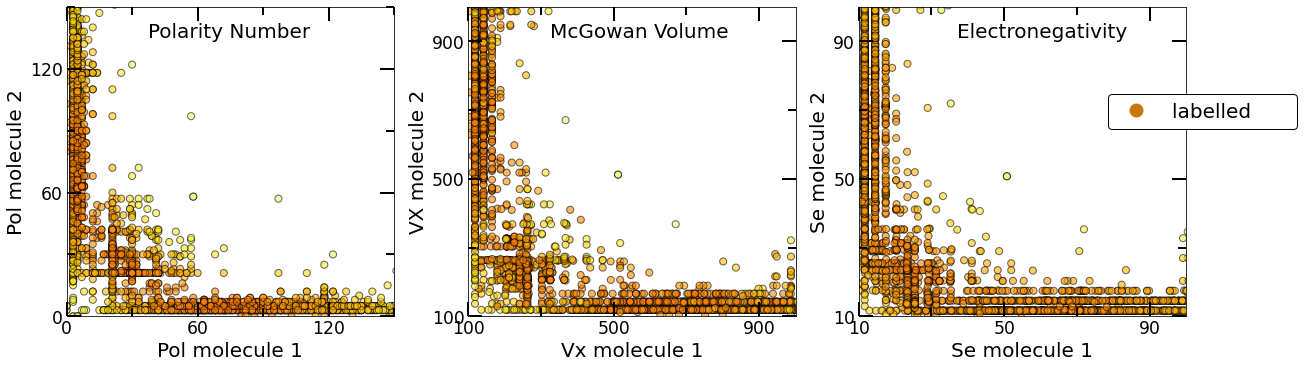

In [ ]:
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
x1= pd.concat([dataset1['Pol'] , dataset2['Pol']])  # dataset1['Ram']
y1= pd.concat([dataset2['Pol'] , dataset1['Pol']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
#z=lab
ax0.text(0.25, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia)#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
# Experomental Compounds

ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(0, 150)
ax0.set_ylim(0, 150)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 150.1, 60)
minor_ticks_x = np.arange(0, 150.1, 30)
major_ticks_y = np.arange(0, 150.1, 60)
minor_ticks_y = np.arange(0, 150.1, 30)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)

#Volume
x1= pd.concat([dataset1['Vx'] , dataset2['Vx']])  # dataset1['Ram']
y1= pd.concat([dataset2['Vx'] , dataset1['Vx']])
z = gaussian_kde(x1y1)(x1y1)

ax1.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.25, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
# Experimental COmpounds

ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(100, 1000)
ax1.set_ylim(100, 1000)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(100, 1000, 400)
minor_ticks_x = np.arange(100, 1000, 200)
major_ticks_y = np.arange(100, 1000, 400)
minor_ticks_y = np.arange(100, 1000, 200)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

#Electronic
x1= pd.concat([dataset1['Se'] , dataset2['Se']])  # dataset1['Ram']
y1= pd.concat([dataset2['Se'] , dataset1['Se']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)

ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=50, alpha=0.6, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Labelled')#plt.cm.Wistia)#, zorder=2)
ax2.text(0.3, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
    
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(10, 100)
ax2.set_ylim(10, 100)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100, 40)
minor_ticks_x = np.arange(10, 100, 20)
major_ticks_y = np.arange(10, 100, 40)
minor_ticks_y = np.arange(10, 100, 20)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
#fig.colorbar(ax2=ax2, orientation='horizontal')



#leg = plt.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
         #   borderaxespad=1, frameon=False) loc=(0.75, -0.15),

from matplotlib.lines import Line2D
red_circle = Line2D([0], [0], marker='o', color='w', label='labelled      ', 
                        markerfacecolor='#c87606', markersize=15),
plt.legend(handles=red_circle, bbox_to_anchor= (0.73, 0.75) , ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')  # bbox_to_anchor= (1.2, 0.65)

#plt.savefig('figure9_lab_scores.png', dpi=600)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


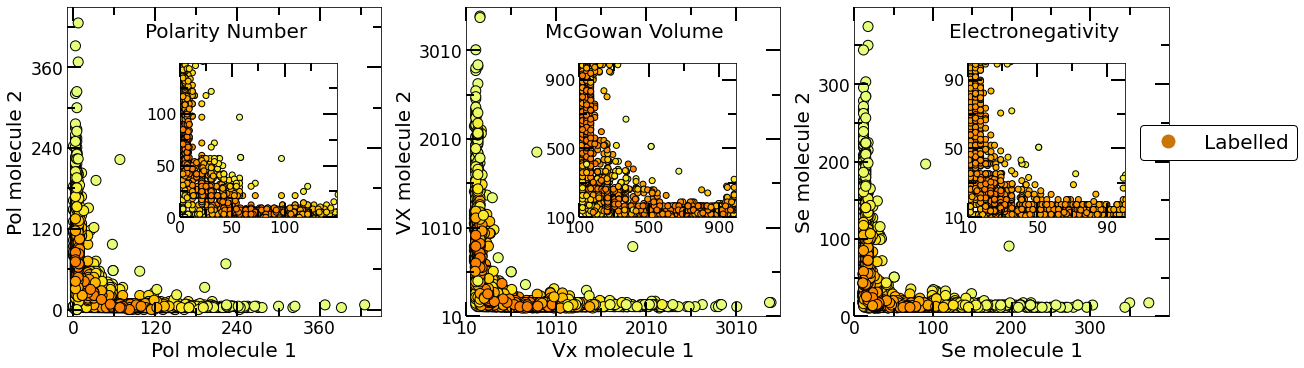

In [ ]:
import matplotlib.font_manager
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"

fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
x1= pd.concat([dataset1['Pol'] , dataset2['Pol']])  # dataset1['Ram']
y1= pd.concat([dataset2['Pol'] , dataset1['Pol']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
#z=lab
ax0.text(0.25, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black',  cmap=plt.cm.Wistia)#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(-10, 450)
ax0.set_ylim(-10, 450)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 450, 120)
minor_ticks_x = np.arange(0, 450, 60)
major_ticks_y = np.arange(0, 450, 120)
minor_ticks_y = np.arange(0, 450, 60)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
sub_axes = ax0.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(0, 150)
sub_axes.set_ylim(0, 150)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 150, 50)
minor_ticks_x = np.arange(0, 150, 25)
major_ticks_y = np.arange(0, 150, 50)
minor_ticks_y = np.arange(0, 150, 25)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)


#Volume
x1= pd.concat([dataset1['Vx'] , dataset2['Vx']])  # dataset1['Ram']
y1= pd.concat([dataset2['Vx'] , dataset1['Vx']])
z = gaussian_kde(x1y1)(x1y1)

ax1.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black', cmap=plt.cm.Wistia, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.25, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(10, 3500)
ax1.set_ylim(10, 3500)
major_ticks_x = np.arange(10,  3500, 1000)
minor_ticks_x = np.arange(10,  3500, 500)
major_ticks_y = np.arange(10, 3500, 1000)
minor_ticks_y = np.arange(10,  3500, 500)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
sub_axes = ax1.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(100, 1000)
sub_axes.set_ylim(100, 1000)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(100, 1000, 400)
minor_ticks_x = np.arange(100, 1000, 200)
major_ticks_y = np.arange(100, 1000, 400)
minor_ticks_y = np.arange(100, 1000, 200)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)


#Electronic
x1= pd.concat([dataset1['Se'] , dataset2['Se']])  # dataset1['Ram']
y1= pd.concat([dataset2['Se'] , dataset1['Se']])
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)

ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=100, alpha=1, c=z , edgecolors='black',  cmap=plt.cm.Wistia, label='Labelled')#plt.cm.Wistia)#, zorder=2)
ax2.text(0.3, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
    
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(0, 400)
ax2.set_ylim(0, 400)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 400, 100)
minor_ticks_x = np.arange(0, 400, 50)
major_ticks_y = np.arange(0, 400, 100)
minor_ticks_y = np.arange(0, 400, 50)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
#fig.colorbar(ax2=ax2, orientation='horizontal')
sub_axes = ax2.inset_axes([0.36, 0.32, .5, .5])
sub_axes.scatter(x1,y1, c = z, cmap='Wistia' , edgecolors='black') #Wistia
sub_axes.tick_params(labelsize=16)
sub_axes.spines['left'].set_color('black')
sub_axes.spines['bottom'].set_color('black')
sub_axes.set_xlim(10, 100)
sub_axes.set_ylim(10, 100)
sub_axes.tick_params(axis = 'both', which='both', width=2)
sub_axes.tick_params(axis = 'both', which='major', length=14)
sub_axes.tick_params(axis = 'both', which='minor', length=8, color='black')
sub_axes.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100.1, 40)
minor_ticks_x = np.arange(10, 100.1, 20)
major_ticks_y = np.arange(10, 100.1, 40)
minor_ticks_y = np.arange(10, 100.1, 20)
sub_axes.set_xticks(major_ticks_x)
sub_axes.set_xticks(minor_ticks_x, minor=True)
sub_axes.set_yticks(major_ticks_y)
sub_axes.set_yticks(minor_ticks_y, minor=True)



#leg = plt.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
         #   borderaxespad=1, frameon=False) loc=(0.75, -0.15),

from matplotlib.lines import Line2D
red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
plt.legend(handles=red_circle,  bbox_to_anchor= (1.44, 0.65), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')

plt.savefig('figure9_lab_scores_inset.png', dpi=600)

In [ ]:
df1_w=dataset1.iloc[:,2:]
df2_w=dataset2.iloc[:,2:]
data = pd.concat([df1_w, df2_w])
data_ = data.drop_duplicates(keep=False)
print(df1_w.shape)
print(df2_w.shape)

# Drop the highly linearly correlated features among the datasets
# Create correlation matrix

corr_matrix1 = data_.corr(method='spearman').abs()


(1722, 1857)
(1722, 1857)


In [ ]:
test_score = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabelled_deep.csv')
test_score['test_score'][test_score['test_score'] < 0] = 0
unlab = pd.concat([pd.DataFrame(uf_final.comb.values, columns=['Identifier']), pd.DataFrame(test_score.test_score, columns=['test_score'])], axis=1)
combinations = unlab[unlab.test_score> 0.7].Identifier.values
len(combinations) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


4511

In [ ]:
test = uf_final[uf_final.comb.isin(combinations)]
test_all =  uf_final[~uf_final.comb.isin(combinations)]

In [ ]:
def feature(feat):
  data = pd.concat([pd.DataFrame(df[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(df[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data['label'] = 'labeled'

  data1 = pd.concat([pd.DataFrame(test[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data1['label'] = 'inliers'

  data2 = pd.concat([pd.DataFrame(test_all[feat].iloc[:, 0].values, columns=['x']),pd.DataFrame(test_all[feat].iloc[:, 1].values, columns=['y']) ], axis=1)
  data2['label'] = 'unlabeled'

  data_all = pd.concat([data, data1, data2])
  return data_all

data_all = feature('Pol')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.


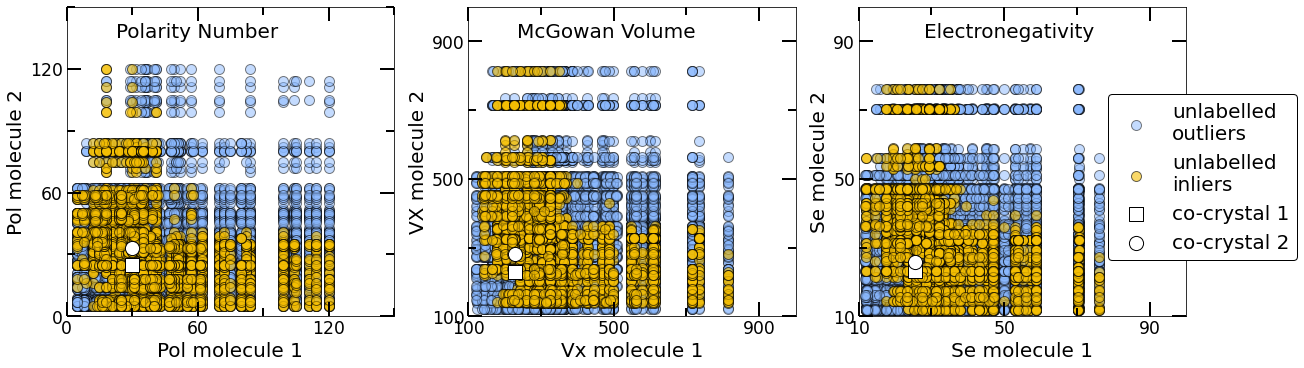

In [ ]:
import matplotlib.font_manager
from matplotlib import cm
from scipy.stats import gaussian_kde
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
fig, axes = plt.subplots(figsize=(18,5),nrows=1, ncols=3,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
ax0, ax1, ax2= axes.flatten()

top = cm.get_cmap('viridis', 128)
bottom = cm.get_cmap('Wistia', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0.2, 1, 128))))
#newcmp = ListedColormap(newcolors, name='OrangeBlue')

# Polarity
data_all = feature('Pol')
data = data_all[data_all.label == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax0.scatter(data.x, data.y,s=100, alpha=0.5, color='#8ab8fe', edgecolors='black' )#, label = 'Unlabelled')
ax0.text(0.15, 0.9, 'Polarity Number', transform=ax0.transAxes, ha="left" ,fontsize=20)
#plt.scatter(x,y, edgecolors='black', c=z,  cmap=plt.cm.Wistia ,s=200, label = 'Labeled')  #'orange' #'xkcd:tangerine'
#sns.scatterplot(x='x', y='y', data = data_all[data_all.label == 'inliers'],   s=50, alpha=1, c=z , edgecolor='black' ,ax=ax)# , label = 'Highly Scored Part of Unlabelled Dataset') #xkcd:tangerine
ax0.axis(aspect='equal')
ax0.set(adjustable='box')#, aspect='equal')
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.axis('on')
ax0.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')#, label='Inliers')#plt.cm.Wistia)#, zorder=2)
# Experomental Compounds
ax0.scatter(30, 25, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax0.scatter(30, 33, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax0.grid(False)
ax0.set_facecolor('xkcd:white')
ax0.set_xlabel("Pol molecule 1",fontsize=20)
ax0.set_ylabel("Pol molecule 2",fontsize=20)
ax0.set_xlim(0, 150)
ax0.set_ylim(0, 150)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction = 'in')
major_ticks_x = np.arange(0, 150.1, 60)
minor_ticks_x = np.arange(0, 150.1, 30)
major_ticks_y = np.arange(0, 150.1, 60)
minor_ticks_y = np.arange(0, 150.1, 30)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)

#Volume
data_all = feature('Vx')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']

#x1y1 = np.vstack([x1,y1])
#z = gaussian_kde(x1y1)(x1y1)
ax1.scatter(data.x, data.y,s=100, alpha=0.5, color='#8ab8fe', edgecolors='black')
ax1.scatter(x1, y1,   s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers') #, label='Inliers')#plt.cm.Wistia)#, zorder=2)
ax1.text(0.15, 0.9, 'McGowan Volume', 
        transform=ax1.transAxes, ha="left" ,fontsize=20)
ax1.axis(aspect='equal')
ax1.set(adjustable='box')#, aspect='equal')
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.axis('on')
# Experomental COmpounds
ax1.scatter(227.911, 228.115, color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
ax1.scatter(227.911, 281.964, color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
ax1.grid(False)
ax1.set_facecolor('xkcd:white')
ax1.set_xlabel("Vx molecule 1",fontsize=20)
ax1.set_ylabel("VX molecule 2",fontsize=20)
ax1.set_xlim(100, 1000)
ax1.set_ylim(100, 1000)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True , direction = 'in')
major_ticks_x = np.arange(100, 1000.1, 400)
minor_ticks_x = np.arange(100, 1000.1, 200)
major_ticks_y = np.arange(100, 1000.1, 400)
minor_ticks_y = np.arange(100, 1000.1, 200)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

#Electronic
data_all = feature('Se')
data = data_all[data_all.label  == 'unlabeled']
x1=data_all[data_all.label == 'inliers']['x']
y1=data_all[data_all.label == 'inliers']['y']
x1y1 = np.vstack([x1,y1])
z = gaussian_kde(x1y1)(x1y1)
ax2.scatter(data.x, data.y,s=100, alpha=0.5, color='#8ab8fe', edgecolors='black', label = 'unlabelled\noutliers' )
ax2.axis(aspect='equal')
ax2.set(adjustable='box')#, aspect='equal')
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.axis('on')
ax2.scatter(x1, y1,  s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='unlabelled\ninliers')

ax2.text(0.2, 0.9, 'Electronegativity', transform=ax2.transAxes, ha="left" ,fontsize=20)
# Experomental Compounds
ax2.scatter(25.418, 23.183, color='white', s=200, label='co-crystal 1',marker = 's', edgecolors='black')
ax2.scatter(25.418, 25.854, color='white', s=200,marker = 'o', label='co-crystal 2',edgecolors='black')         
ax2.grid(False)
ax2.set_facecolor('xkcd:white')
ax2.set_xlabel("Se molecule 1",fontsize=20)
ax2.set_ylabel("Se molecule 2",fontsize=20)
ax2.set_xlim(10, 100)
ax2.set_ylim(10, 100)
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(10, 100, 40)
minor_ticks_x = np.arange(10, 100, 20)
major_ticks_y = np.arange(10, 100, 40)
minor_ticks_y = np.arange(10, 100, 20)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)

ax2.set_yticks(minor_ticks_y, minor=True)
#ax2.legend(loc='lower left', bbox_to_anchor= (0.8, 0.45), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
plt.legend( bbox_to_anchor= (0.73, 0.75), ncol=1, fontsize=20, facecolor='white', framealpha=1, edgecolor='black')
#plt.savefig('figure9_unlab.png', dpi=600)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


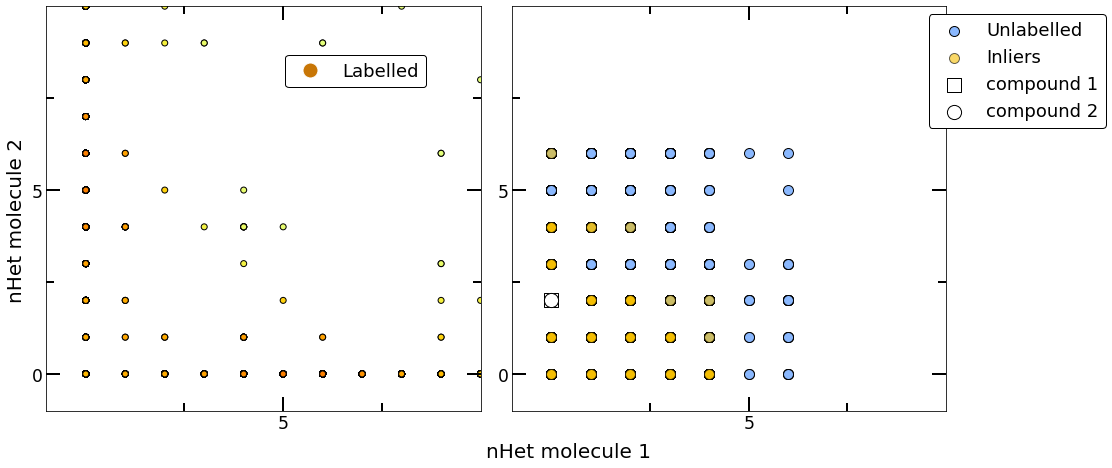

In [ ]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


def feature_distribution(descriptor):
  fig, axes = plt.subplots(figsize=(15,6),nrows=1, ncols=2,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
  ax1, ax0= axes.flatten()
  data_all = feature(descriptor)
  data = data_all[data_all.label == 'unlabeled']
  ax0.scatter(data.x, data.y,s=100, alpha=1, color='#8ab8fe', edgecolors='black' , label = 'Unlabelled')
  ax0.axis(aspect='equal')
  ax0.set(adjustable='box')
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.spines['bottom'].set_color('black')
  ax0.spines['top'].set_color('black')
  ax0.spines['right'].set_color('black')
  ax0.spines['left'].set_color('black')
  ax0.axis('on')
  ax0.scatter(data_all[data_all.label == 'inliers']['x'], data_all[data_all.label == 'inliers']['y'], s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')
  
  # Experimental Compounds
  ax0.scatter(uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 1], color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
  ax0.scatter(uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 1], color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.set_xlim(-1, 10)
  ax0.set_ylim(-1, 10)
  ax0.legend(loc= (0.96, 0.7), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')

  x1=data_all[data_all.label == 'labeled']['x']
  y1=data_all[data_all.label == 'labeled']['y']
  x1y1 = np.vstack([x1,y1])
  z = gaussian_kde(x1y1)(x1y1)
  ax1.scatter(x1,y1, edgecolors='black', c=z,  cmap=plt.cm.Wistia, label='Labeled')
  ax1.set_xlim(-1, 10)
  ax1.set_ylim(-1, 10)
  red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
  ax1.legend(handles=red_circle,  loc= (0.55, 0.8), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')


  fig.text(0.5, -0.05, '%s molecule 1'%descriptor, ha='center',fontsize=20 )
  fig.text(-0.02, 0.5, '%s molecule 2'%descriptor, va='center', rotation='vertical', fontsize=20)


  major_ticks_x = np.arange(0, 10, 5)
  minor_ticks_x = np.arange(0, 10, 2.5)
  major_ticks_y = np.arange(0, 10, 5)
  minor_ticks_y = np.arange(0, 10, 2.5)
  for ax in axes.flatten():
    set_spines(ax)
    set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x )
  #fig.tight_layout(pad=3)


def set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x ):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                   top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.xaxis.get_major_ticks()[0].draw = lambda *args:None


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')



feature_distribution('nHet')
#plt.savefig('nHet.png',  dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


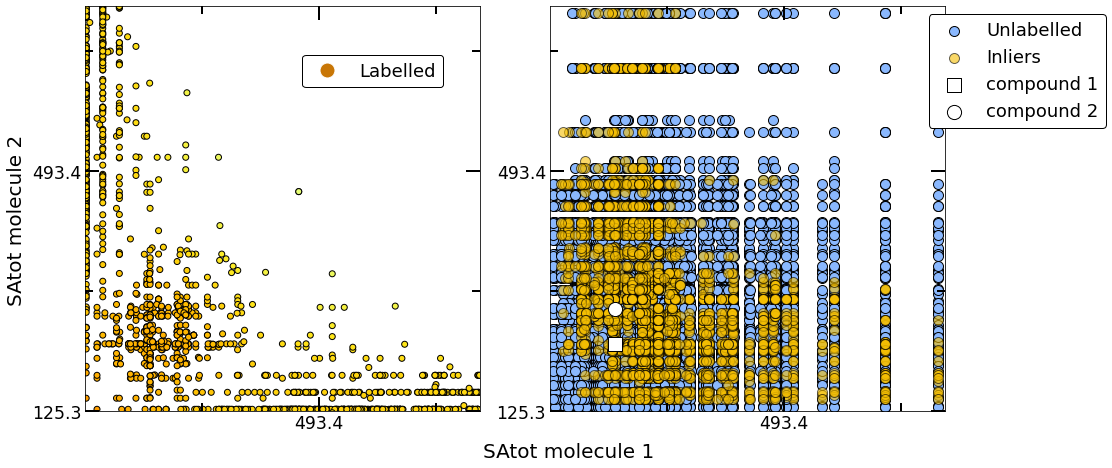

In [ ]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


def feature_distribution(descriptor):
  fig, axes = plt.subplots(figsize=(15,6),nrows=1, ncols=2,constrained_layout=True, gridspec_kw = {'wspace':0.05, 'hspace':0.1})
  ax1, ax0= axes.flatten()
  data_all = feature(descriptor)
  data = data_all[data_all.label == 'unlabeled']
  ax0.scatter(data.x, data.y,s=100, alpha=1, color='#8ab8fe', edgecolors='black' , label = 'Unlabelled')
  ax0.axis(aspect='equal')
  ax0.set(adjustable='box')
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.spines['bottom'].set_color('black')
  ax0.spines['top'].set_color('black')
  ax0.spines['right'].set_color('black')
  ax0.spines['left'].set_color('black')
  ax0.axis('on')
  ax0.scatter(data_all[data_all.label == 'inliers']['x'], data_all[data_all.label == 'inliers']['y'], s=100, alpha=0.6, edgecolors='black', color='#f5bf03', label='Inliers')
  
  # Experimental Compounds
  ax0.scatter(uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1799'][descriptor].iloc[:, 1], color='white', s=200, label='compound 1',marker = 's', edgecolors='black')
  ax0.scatter(uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 0], uf_final[uf_final.comb == 'comb1817'][descriptor].iloc[:, 1], color='white', s=200,marker = 'o', label='compound 2',edgecolors='black')  
  ax0.grid(False)
  ax0.set_facecolor('xkcd:white')
  ax0.set_xlim(data.min()[0]-5, data.max()[0]+10)
  ax0.set_ylim(data.min()[0]-5, data.max()[0]+10)
  ax0.legend(loc= (0.96, 0.7), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')

  x1=data_all[data_all.label == 'labeled']['x']
  y1=data_all[data_all.label == 'labeled']['y']
  x1y1 = np.vstack([x1,y1])
  z = gaussian_kde(x1y1)(x1y1)
  ax1.scatter(x1,y1, edgecolors='black', c=z,  cmap=plt.cm.Wistia, label='Labeled')
  ax1.set_xlim(data.min()[0]-5, data.max().any()+10)
  ax1.set_ylim(data.min()[0]-5, data.max().any()+10)
  red_circle = Line2D([0], [0], marker='o', color='w', label='Labelled',
                        markerfacecolor='#c87606', markersize=15),
  ax1.legend(handles=red_circle,  loc= (0.55, 0.8), ncol=1, fontsize=18, facecolor='white', framealpha=1, edgecolor='black')


  fig.text(0.5, -0.05, '%s molecule 1'%descriptor, ha='center',fontsize=20 )
  fig.text(-0.02, 0.5, '%s molecule 2'%descriptor, va='center', rotation='vertical', fontsize=20)


  major_ticks_x = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/2)
  minor_ticks_x = np.arange(data.min()[0]-5, data.max()[0]+0.1,data.max().any()/4)
  major_ticks_y = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/2)
  minor_ticks_y = np.arange(data.min()[0]-5, data.max()[0]+0.1, data.max().any()/4)
  for ax in axes.flatten():
    set_spines(ax)
    set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x )
  #fig.tight_layout(pad=3)


def set_ticks(ax,major_ticks_x, major_ticks_y, minor_ticks_y, minor_ticks_x ):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                   top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.xaxis.get_major_ticks()[0].draw = lambda *args:None


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')



feature_distribution('SAtot')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


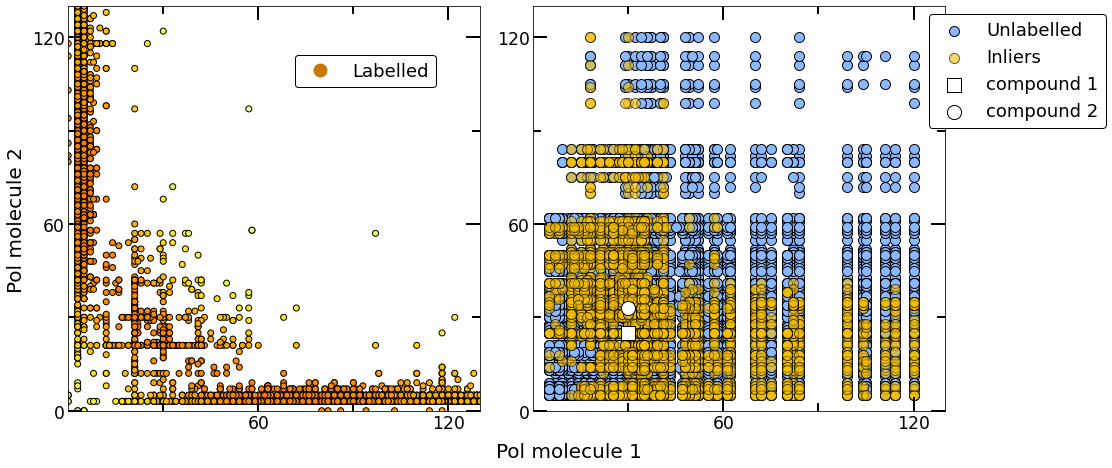

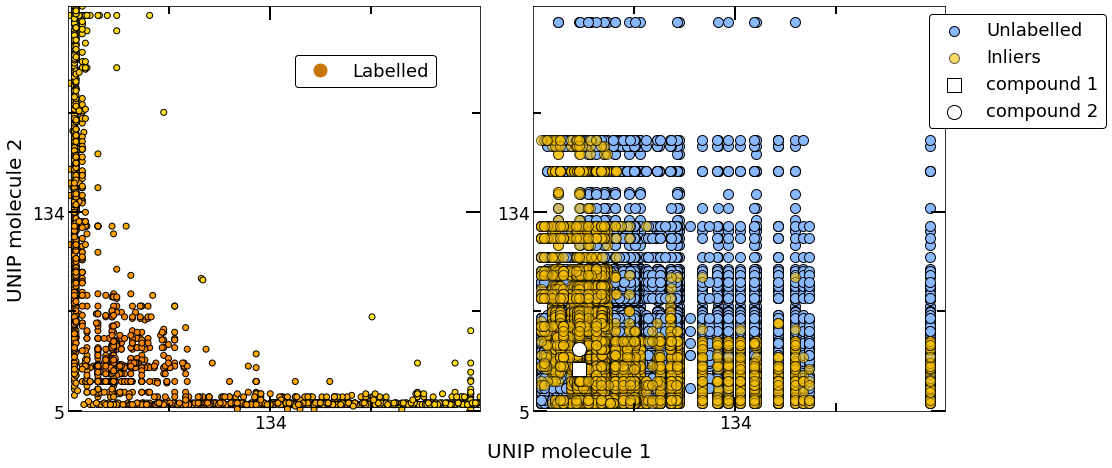

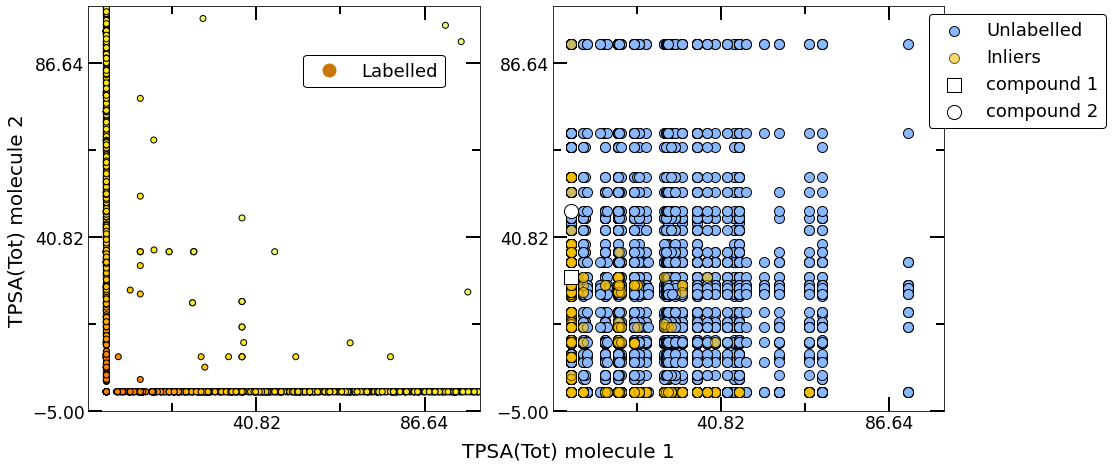

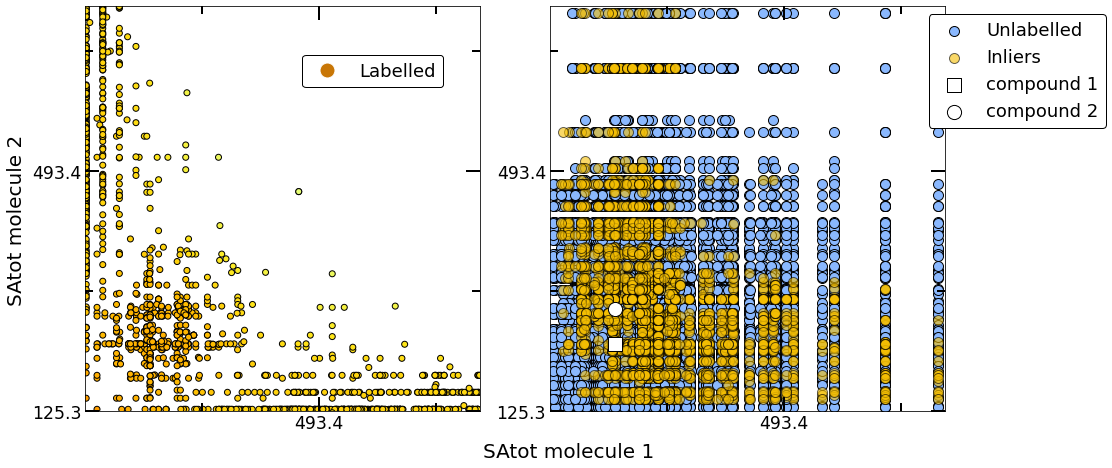

In [ ]:
# Polarity Descriptors
polarity_descr = ['Pol', 'UNIP', 'TPSA(Tot)', 'SAtot']

for i in polarity_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


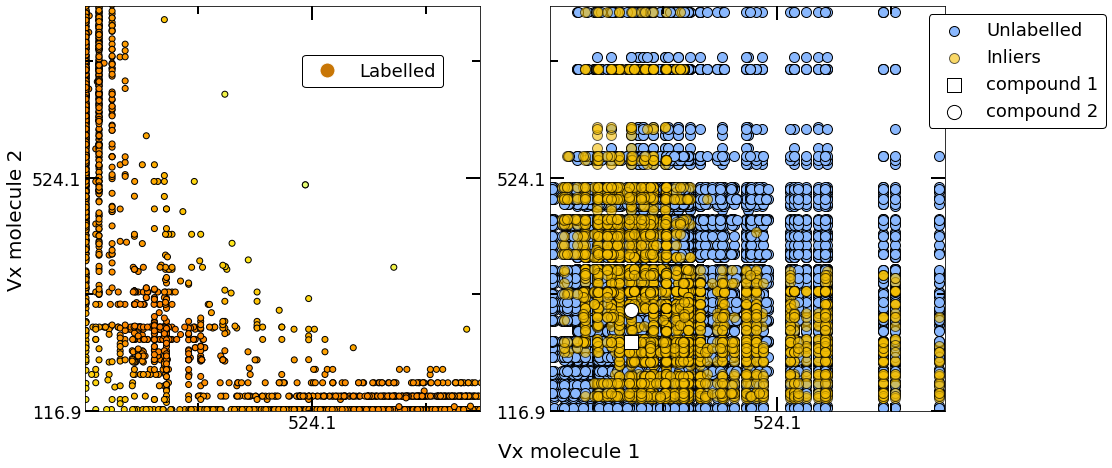

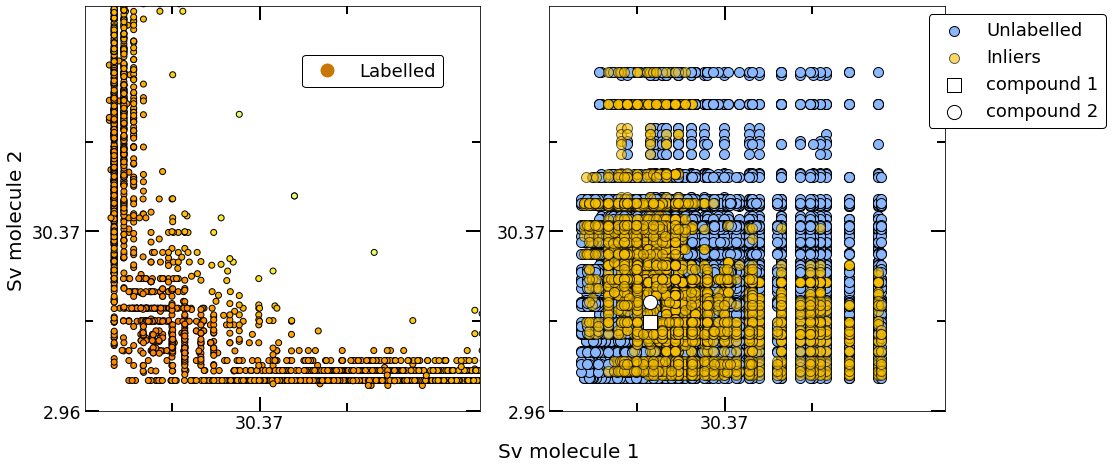

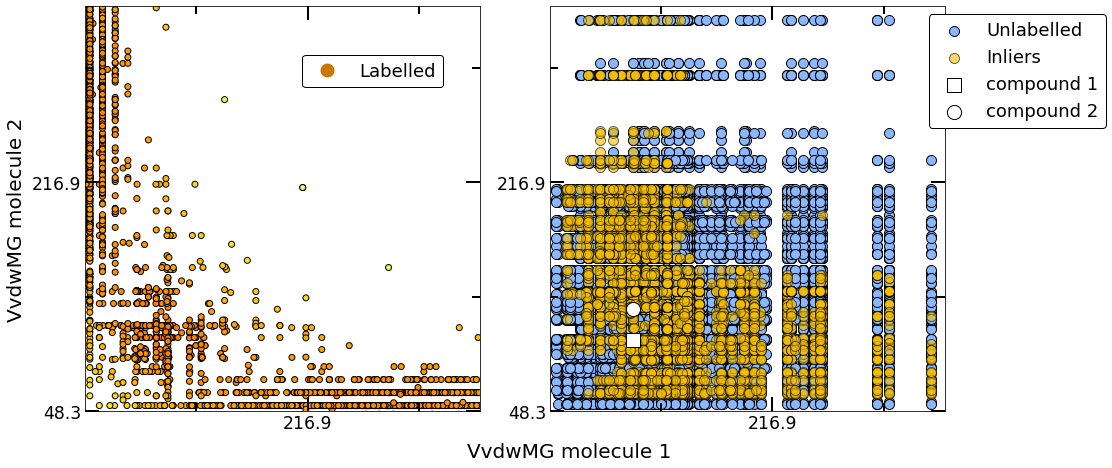

In [ ]:
# Size descriptors
size_descr = ['Vx', 'Sv', 'VvdwMG']

for i in size_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


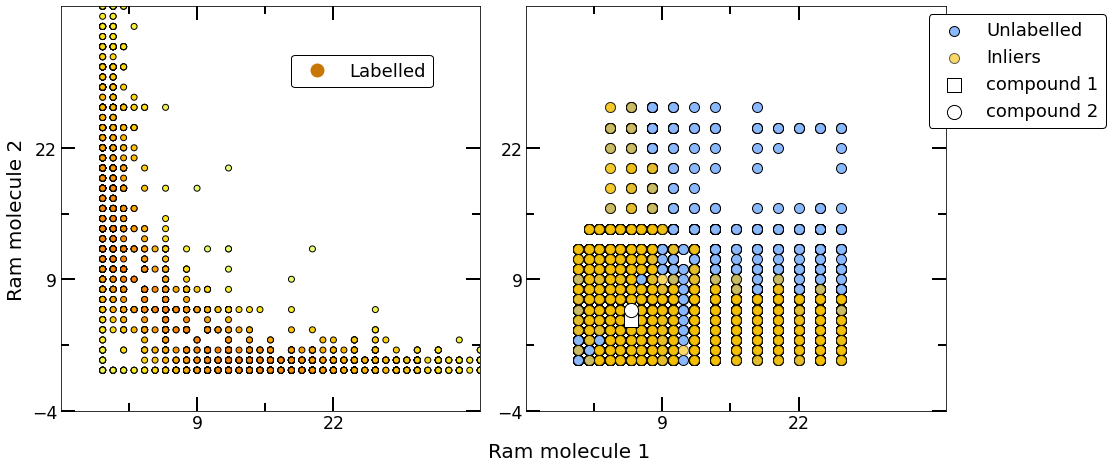

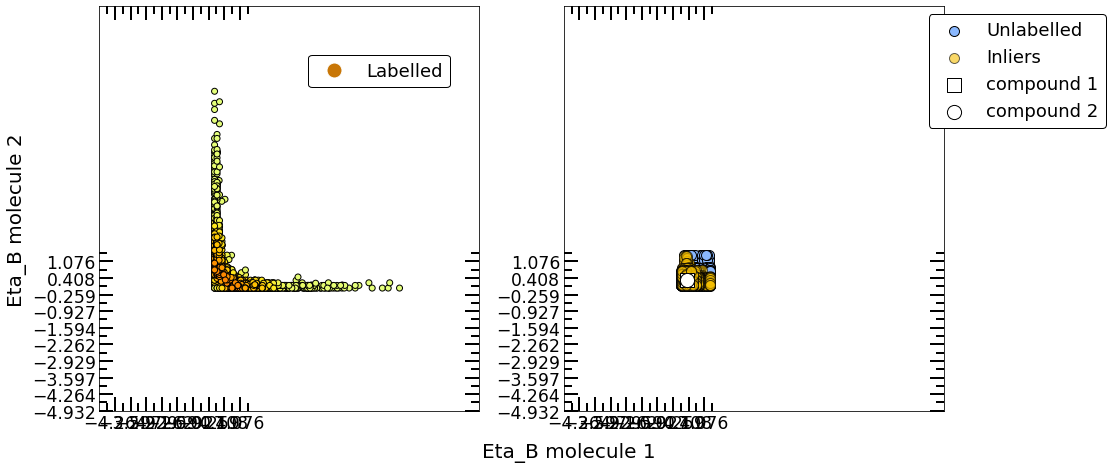

In [ ]:
# Shape descriptors
shape_descr = ['Ram', 'Eta_B' ]

for i in shape_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


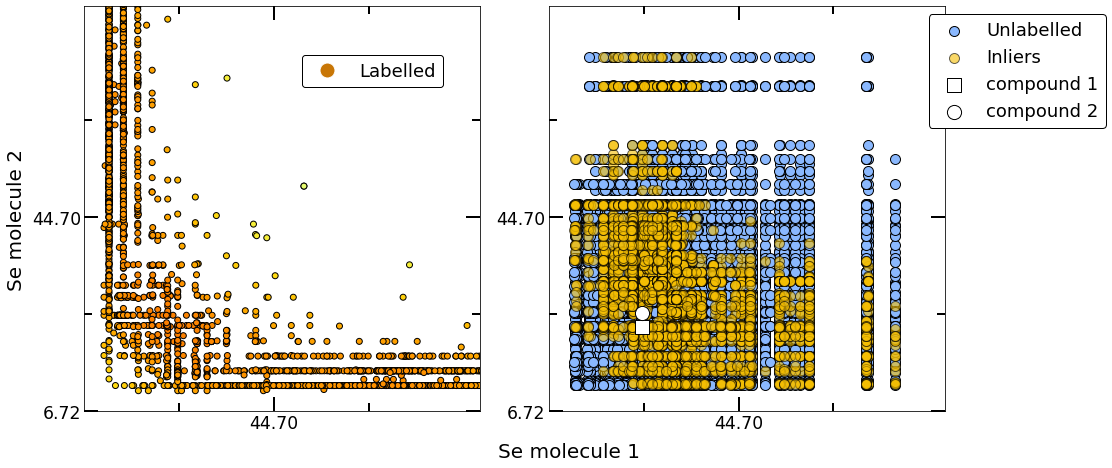

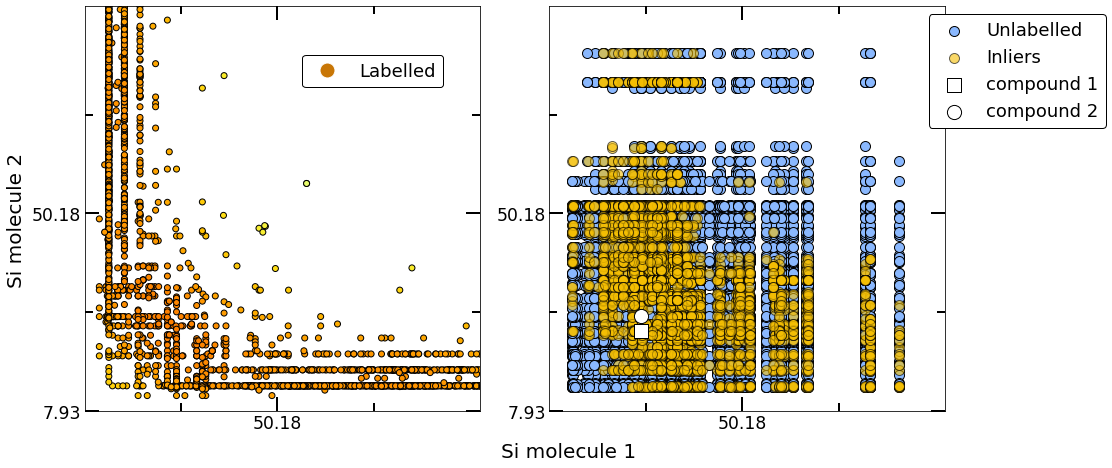

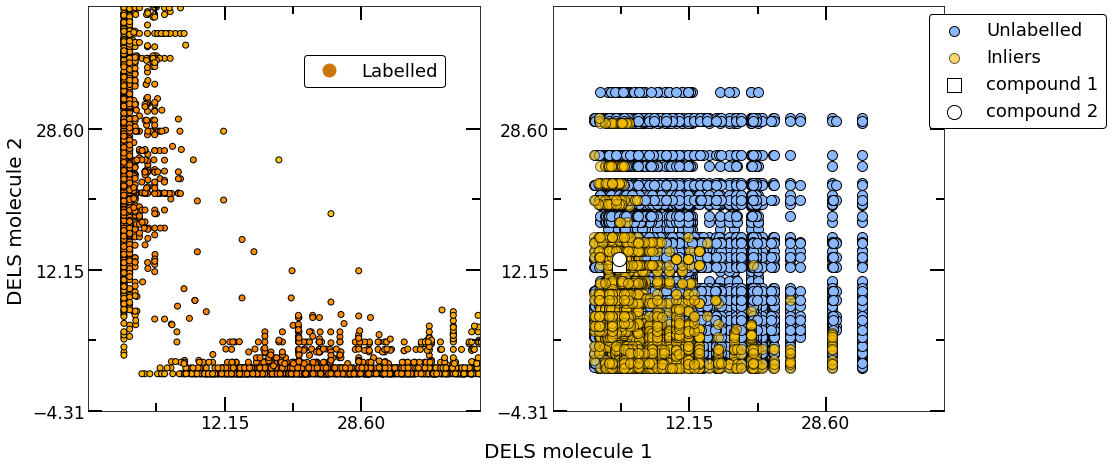

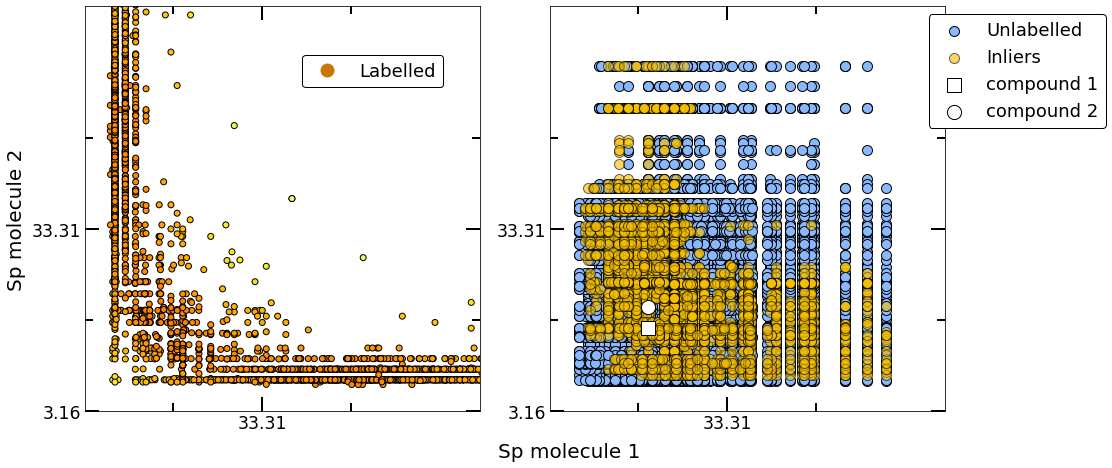

In [ ]:
# Electronic properties descriptors
electr_descr = ['Se', 'Si', 'DELS', 'Sp']

for i in electr_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  del sys.path[0]


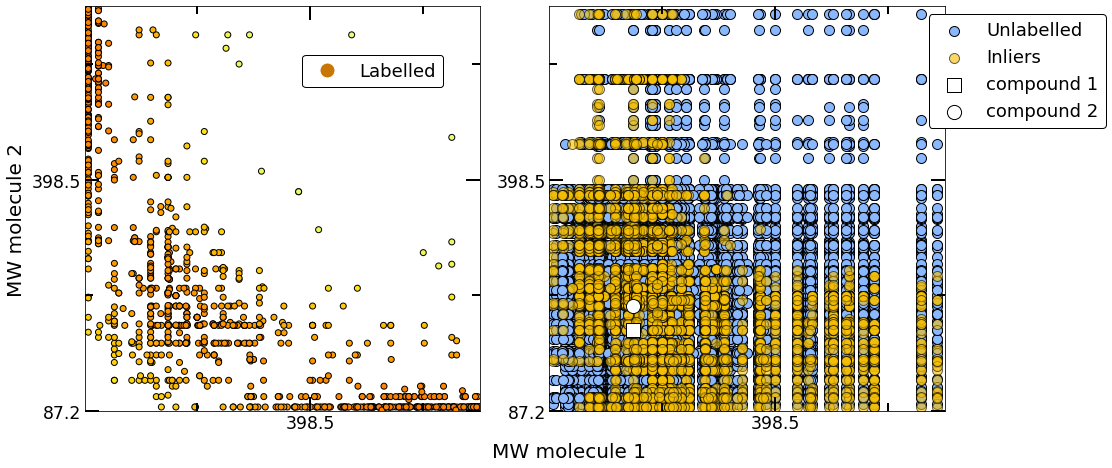

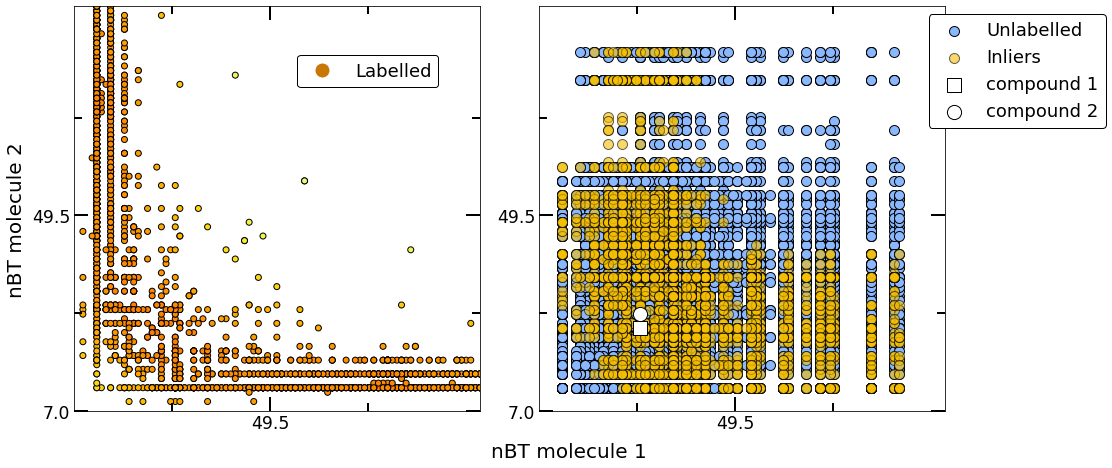

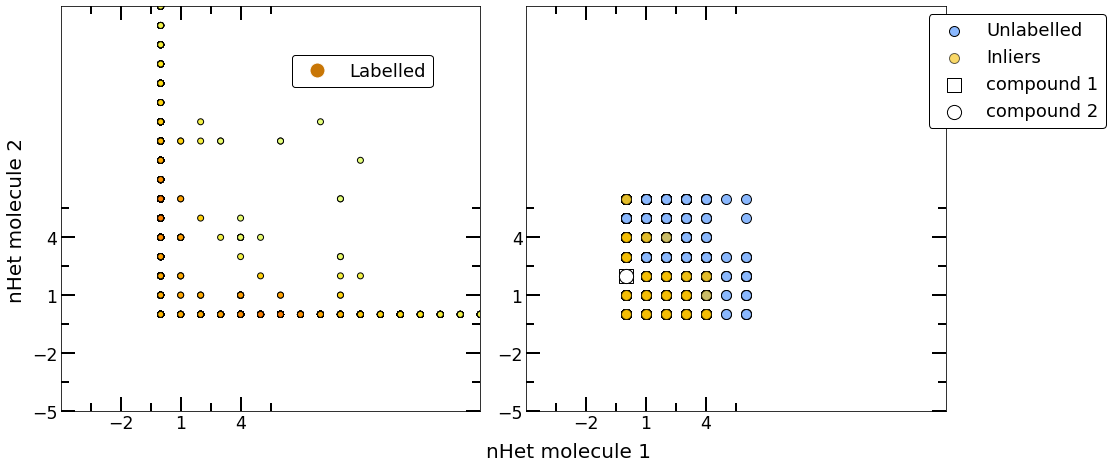

In [ ]:
# General descriptors
general_descr =['MW', 'nBT', 'nHet']

for i in general_descr:
  feature_distribution(i)
  #plt.savefig('%s.png'%i, dpi=600,rasterized=True,  bbox_inches="tight")